<a id='Title-Word-Embeddings'></a>
<h1 style="color:SlateGray;">Word Embeddings</h1>

**Input dataset**

IMBD: a set of movie reviews with an adjustable limit on max word count.

ACL IMBD: a larger set of movie reviews than the IMBD dataset.


**Output classification**

Binary categorization (positive/negative) of a movie review.

<h2 style="color:SlateGray;">Background</h2>

**Pre-trained models**

<a id='Pre-trained-models-GloVe'></a>
*GloVe*

A pre-trained word embedding that's useful for general text classification.

Trained on 400,000 tokens using co-occurrence statistics, which map unique linear substructures in the embedding's vector space.

**Layers**

[*Dense*](01_Image_Classification.ipynb#Layers-Dense)


**Activations**

[*relu*](01_Image_Classification.ipynb#Activations-relu)

[*sigmoid*](02_Binary_Classification.ipynb#Activations-sigmoid)
		
**Optimizers**

[*rmsprop*](01_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

[*binary_crossentropy*](02_Binary_Classification.ipynb#Loss-functions-binary_crossentropy)

<h2 style="color:SlateGray;">Overview</h2>

Revisiting the IMBD classification problm using Embeddings, also a comparison in performance between randomly initialized and pre-trained Embeddings when training on very limited samples.

This IMBD example leverages an 8-dimensional Embedding that only looks at the first 20 words of each sample, while still training on the full set of samples. The model comparison of pre-trained vs. randomly initialized Embeddings, on the other hand, are trained on a mere 200 samples before validation. The two models used have 300-dimensional Embeddings, where the pre-trained Embedding's dimensions are initialized from the GloVe model's weights and are subsequently frozen.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 313us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 2s 97us/step - loss

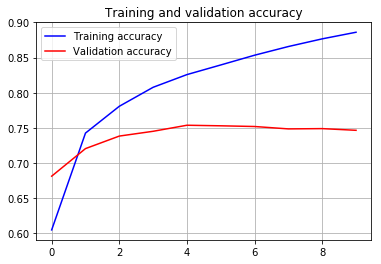

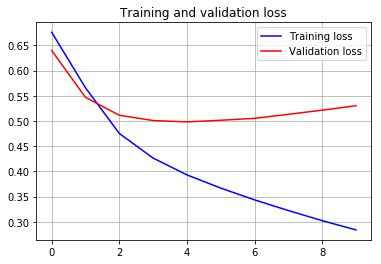

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [7]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())    
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [9]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [10]:
glove_dir = './glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [14]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 2.0163 - acc: 0.5200 - val_loss: 0.7546 - val_acc: 0.5095
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3468 - acc: 0.8000 - val_loss: 0.7473 - val_acc: 0.5392
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3085 - acc: 0.8700 - val_loss: 1.4648 - val_acc: 0.4939
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1115 - acc: 0.9650 - val_loss: 0.7137 - val_acc: 0.5844
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0249 - acc: 1.0000 - val_loss: 0.7460 - val_acc: 0.5695
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.7313 - val_acc: 0.5807
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.7885 - val_acc: 0.5724
Epoch 8/10
200/200 [========

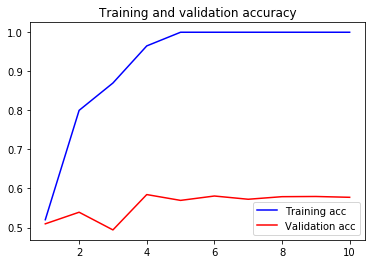

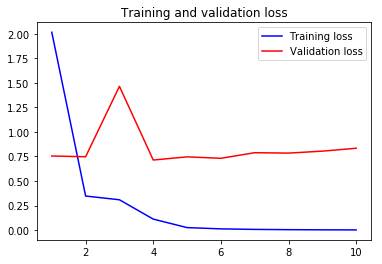

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 50us/step


[0.8263695372390747, 0.57764]

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6952 - acc: 0.4900 - val_loss: 0.7062 - val_acc: 0.5077
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2876 - a

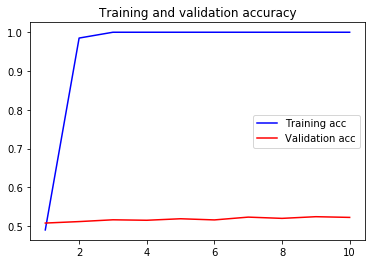

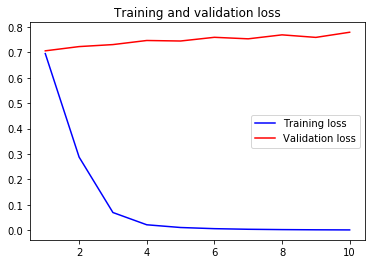

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 51us/step


[0.776522950592041, 0.52664]